# Supervised Learning Using Keras

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from imblearn.keras import BalancedBatchGenerator

from clean_data import clean_data
from preprocess import make_preprocessor, get_columns

## Part 2: Supervised Learning Model

In [13]:
mailout_train = pd.read_csv('../data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Users\Mei\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
mailout_train.shape

(42962, 367)

In [15]:
y = mailout_train.RESPONSE
X = mailout_train.drop('RESPONSE', axis=1)

In [10]:
y.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [11]:
y.value_counts() / y.shape[0] * 100

0    98.761696
1     1.238304
Name: RESPONSE, dtype: float64

In [5]:
# Load feature info
feat_info = pd.read_csv('../features.csv')
feat_info.set_index('attribute', inplace=True)

# Parse missing_or_known string into a list
def parse_missing(s):
    a = s[1:-1].split(',')
    return a

feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(parse_missing)

### Get to know the data

In [13]:
X_clean = X

# Drop columns not in data dictionary
#missing_from_feat_info = set(X_clean.columns.values).difference(feat_info.index.values)
#X_clean.drop(list(missing_from_feat_info), axis='columns', inplace=True)

# Convert missing values to Nans
missing_values = pd.Series(feat_info['missing_or_unknown'].values, index=feat_info.index).to_dict()
X_clean[X_clean.isin(missing_values)] = np.nan

In [14]:
X_clean.shape

(42962, 366)

In [15]:
# Missing values by column
p_missing = (X_clean.isnull().sum() / X_clean.shape[0])
p_missing.sort_values(ascending=False).head(20)

ALTER_KIND4       0.999046
ALTER_KIND3       0.995950
TITEL_KZ          0.995042
ALTER_KIND2       0.982403
ALTER_KIND1       0.953727
KK_KUNDENTYP      0.589265
KBA05_BAUMAX      0.534891
AGER_TYP          0.439691
GEBURTSJAHR       0.406755
EXTSEL992         0.371212
ALTER_HH          0.306713
W_KEIT_KIND_HH    0.242470
KKK               0.231134
REGIOTYP          0.231134
HH_DELTA_FLAG     0.225269
KBA05_MOD3        0.210209
KBA05_MOD2        0.210209
KBA05_MOD1        0.210209
KBA05_MAXSEG      0.210209
KBA05_MAXVORB     0.210209
dtype: float64

In [16]:
p_missing.KBA13_ANZAHL_PKW

0.18532656766444766

(array([102.,   0.,   0.,   1., 181.,  70.,   1.,   1.,   0.,   1.,   1.,
          1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   4.]),
 array([0.        , 0.03996183, 0.07992365, 0.11988548, 0.15984731,
        0.19980913, 0.23977096, 0.27973279, 0.31969461, 0.35965644,
        0.39961827, 0.43958009, 0.47954192, 0.51950375, 0.55946557,
        0.5994274 , 0.63938923, 0.67935105, 0.71931288, 0.75927471,
        0.79923653, 0.83919836, 0.87916019, 0.91912201, 0.95908384,
        0.99904567]),
 <a list of 25 Patch objects>)

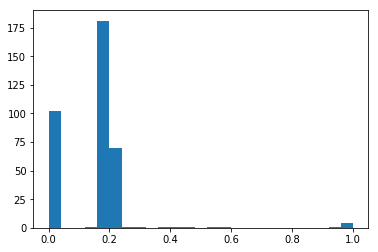

In [14]:
plt.hist(p_missing, bins=25)
#plt.title('% missing values by column')
#plt.ylabel('count')
#plt.xlabel('% missing')

(array([102.,   0.,   0.,   1., 181.,  70.,   1.,   1.,   0.,   1.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ]),
 <a list of 10 Patch objects>)

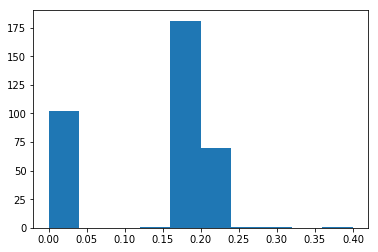

In [15]:
plt.hist(p_missing, range=(0,.4))

In [18]:
col_threshold = .22
to_drop = p_missing[p_missing >= col_threshold]
to_drop.index

Index(['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'EXTSEL992', 'GEBURTSJAHR', 'HH_DELTA_FLAG',
       'KBA05_BAUMAX', 'KK_KUNDENTYP', 'KKK', 'REGIOTYP', 'TITEL_KZ',
       'W_KEIT_KIND_HH'],
      dtype='object')

In [19]:
X_clean = X_clean.drop(to_drop.index, axis=1)
X_clean.shape

(42962, 351)

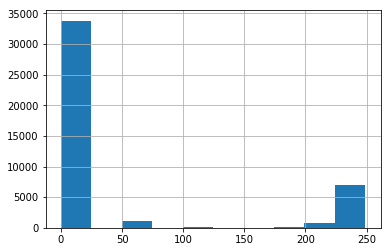

In [20]:
# Missing values by row
n_missing = X_clean.isnull().sum(axis=1)
n_missing.hist();

In [21]:
X_clean['RESPONSE'] = y

In [23]:
above_yes = X_clean[(n_missing > 150) & (X_clean.RESPONSE == 1)]
above_yes.shape[0]

96

Keep all rows because we would lose too many positive responses.

### Clean Data 

In [18]:
X_clean = clean_data(X, feat_info)
print(X_clean.shape)
#print(X_dropped.shape)

(42962, 382)


In [2]:
# Or load cleaned data (includes RESPONSE columns)
mailout_train_clean = pd.read_csv('../data/Udacity_MAILOUT_052018_TRAIN_clean.csv', sep=';')
mailout_train_clean.shape

(42962, 383)

### Preprocess

In [21]:
lnr = mailout_train_clean.LNR
y = mailout_train_clean.RESPONSE
X_clean = mailout_train_clean.drop(['RESPONSE', 'LNR'], axis=1)

In [23]:
X_clean.shape

(42962, 381)

In [22]:
numerical_columns, categorical_columns = get_columns(X_clean.columns, feat_info)
preprocessor = make_preprocessor(numerical_columns, categorical_columns)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.3, stratify=y, random_state=42)

X_train = preprocessor.fit_transform(X_train)
print(pd.value_counts(y_train))

X_test = preprocessor.transform(X_test)
print(pd.value_counts(y_test))

0    29701
1      372
Name: RESPONSE, dtype: int64
0    12729
1      160
Name: RESPONSE, dtype: int64


### Model

In [25]:
def make_model(n_features, learn_rate):
    model = Sequential()

    model.add(Dense(150, input_shape=(n_features,),
              kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(75, kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Dense(25, kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.10))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=learn_rate),
                  metrics=['acc'])

    return model

In [37]:
# Balanced Batches
def fit_predict_balanced_model(X_train, y_train):
    model = make_model(X_train.shape[1], 0.001)
    training_generator = BalancedBatchGenerator(X_train, y_train, batch_size=1000)
    model.fit_generator(generator=training_generator, validation_data=(X_test, y_test), epochs=10, steps_per_epoch=30, verbose=True)
    
    print(roc_auc_score(y_test, y_pred))
    return model

In [ ]:
balanced = fit_predict_balanced_model(X_train, y_train)

Epoch 1/10


In [56]:
y_pred = balanced.predict_proba(X_test)
print(y_pred[0:5])
print(roc_auc_score(y_test, y_pred))

12889/12889 [==============================] - 1s 65us/step
[[0.9966972 ]
 [0.99666864]
 [0.99666864]
 [0.99507964]
 [0.9963127 ]]
0.5367274039594626


In [26]:
# Standard model
def fit_predict_model(X_train, y_train, X_test, y_test, verbose=True, class_weight=None, callbacks=None):
    
    model = make_model(X_train.shape[1], 0.0001)
    
    start_time = time.time()

    model.fit(X_train, y_train, validation_data=(X_test, y_test), 
              epochs=30, verbose=verbose, class_weight=class_weight, callbacks=callbacks)
    
    elapsed_time = time.time() - start_time
    print('Elapsed computation time: {:.3f} secs'
          .format(elapsed_time))

    y_pred = model.predict_proba(X_test)
    print(roc_auc_score(y_test, y_pred))
    
    return model

In [27]:
base = fit_predict_model(X_train, y_train, X_test, y_test)

Train on 30073 samples, validate on 12889 samples
Epoch 1/30
30073/30073 [==============================] - 9s 299us/step - loss: 0.6381 - acc: 0.6697 - val_loss: 0.4409 - val_acc: 0.9687
Epoch 2/30
30073/30073 [==============================] - 7s 231us/step - loss: 0.3862 - acc: 0.9168 - val_loss: 0.2569 - val_acc: 0.9876
Epoch 3/30
30073/30073 [==============================] - 7s 228us/step - loss: 0.2122 - acc: 0.9795 - val_loss: 0.1354 - val_acc: 0.9876
Epoch 4/30
30073/30073 [==============================] - 7s 236us/step - loss: 0.1254 - acc: 0.9861 - val_loss: 0.0880 - val_acc: 0.9876
Epoch 5/30
30073/30073 [==============================] - 7s 246us/step - loss: 0.0902 - acc: 0.9872 - val_loss: 0.0728 - val_acc: 0.9876
Epoch 6/30
30073/30073 [==============================] - 7s 248us/step - loss: 0.0780 - acc: 0.9874 - val_loss: 0.0680 - val_acc: 0.9876
Epoch 7/30
30073/30073 [==============================] - 8s 250us/step - loss: 0.0716 - acc: 0.9876 - val_loss: 0.0665 - 

In [28]:
# Try early stopping
callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

early_stop = fit_predict_model(X_train, y_train, X_test, y_test, callbacks=callbacks)

Train on 30073 samples, validate on 12889 samples
Epoch 1/30
30073/30073 [==============================] - 8s 270us/step - loss: 0.6482 - acc: 0.6387 - val_loss: 0.4538 - val_acc: 0.9847
Epoch 2/30
30073/30073 [==============================] - 7s 236us/step - loss: 0.3917 - acc: 0.9151 - val_loss: 0.2677 - val_acc: 0.9876
Epoch 3/30
30073/30073 [==============================] - 7s 242us/step - loss: 0.2164 - acc: 0.9797 - val_loss: 0.1458 - val_acc: 0.9876
Epoch 4/30
30073/30073 [==============================] - 7s 236us/step - loss: 0.1255 - acc: 0.9862 - val_loss: 0.0928 - val_acc: 0.9876
Epoch 5/30
30073/30073 [==============================] - 7s 238us/step - loss: 0.0904 - acc: 0.9875 - val_loss: 0.0737 - val_acc: 0.9876
Epoch 6/30
30073/30073 [==============================] - 7s 225us/step - loss: 0.0776 - acc: 0.9875 - val_loss: 0.0684 - val_acc: 0.9876
Epoch 7/30
30073/30073 [==============================] - 7s 227us/step - loss: 0.0723 - acc: 0.9876 - val_loss: 0.0669 - 

In [96]:
# Use class weights
y_train.value_counts()[0]/y_train.value_counts()[1]

79.84139784946237

In [29]:
class_weight = {0:1, 1:15}
weighted = fit_predict_model(X_train, y_train, X_test, y_test, class_weight)

Train on 30073 samples, validate on 12889 samples
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
Elapsed computation time: 206.479 secs
0.6521508464922617


In [33]:
y_pred = weighted.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred))

12889/12889 [==============================] - 2s 159us/step
0.648962261371671


In [ ]:
# Dealing with the class imbalance
# Use cluster based
from imblearn.under_sampling import ClusterCentroids

X_trans = preprocessor.fit_transform(X_clean)

cc = ClusterCentroids()
X_cc, y_cc = cc.fit_resample(X_trans, y)

pd.value_counts(y_cc)

In [120]:
print(X_cc.shape)
print(y_cc.shape)

(1064, 346)
(1064,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_cc, y_cc, test_size=0.3, stratify=y, random_state=42)

In [112]:
cc_model = fit_predict_model(X_cc, y_cc, X_test, y_test)

Train on 744 samples, validate on 12889 samples
Epoch 1/10
744/744 [==============================] - 8s 11ms/step - loss: 0.8139 - acc: 0.5040 - val_loss: 0.4669 - val_acc: 0.8025
Epoch 2/10
744/744 [==============================] - 3s 4ms/step - loss: 0.7053 - acc: 0.5914 - val_loss: 0.7396 - val_acc: 0.4351
Epoch 3/10
744/744 [==============================] - 3s 4ms/step - loss: 0.6749 - acc: 0.5981 - val_loss: 1.7595 - val_acc: 0.0747
Epoch 4/10
744/744 [==============================] - 3s 3ms/step - loss: 0.5882 - acc: 0.6640 - val_loss: 3.3447 - val_acc: 0.0264
Epoch 5/10
744/744 [==============================] - 3s 4ms/step - loss: 0.5211 - acc: 0.7554 - val_loss: 3.2633 - val_acc: 0.0153
Epoch 6/10
744/744 [==============================] - 2s 3ms/step - loss: 0.4609 - acc: 0.7984 - val_loss: 5.2565 - val_acc: 0.0126
Epoch 7/10
744/744 [==============================] - 3s 3ms/step - loss: 0.3968 - acc: 0.8333 - val_loss: 8.4511 - val_acc: 0.0124
Epoch 8/10
744/744 [=======

In [26]:
# use SMOTE
from imblearn.over_sampling import SMOTE
X_smote, y_smote = SMOTE().fit_resample(X_train, y_train)

In [27]:
pd.value_counts(y_smote)

1    29701
0    29701
dtype: int64

In [28]:
smote = fit_predict_model(X_smote, y_smote, X_test, y_test)

Train on 59402 samples, validate on 12889 samples
Epoch 1/10
59402/59402 [==============================] - 9s 157us/step - loss: 0.4842 - acc: 0.7433 - val_loss: 0.0922 - val_acc: 0.9876
Epoch 2/10
59402/59402 [==============================] - 9s 153us/step - loss: 0.3043 - acc: 0.8465 - val_loss: 0.5498 - val_acc: 0.7835
Epoch 3/10
59402/59402 [==============================] - 9s 158us/step - loss: 0.2513 - acc: 0.8698 - val_loss: 0.1590 - val_acc: 0.9876
Epoch 4/10
59402/59402 [==============================] - 10s 166us/step - loss: 0.2241 - acc: 0.8806 - val_loss: 0.1204 - val_acc: 0.9875
Epoch 5/10
59402/59402 [==============================] - 9s 153us/step - loss: 0.2102 - acc: 0.8869 - val_loss: 0.1870 - val_acc: 0.9876
Epoch 6/10
59402/59402 [==============================] - 9s 151us/step - loss: 0.1982 - acc: 0.8919 - val_loss: 0.1000 - val_acc: 0.9868
Epoch 7/10
59402/59402 [==============================] - 9s 150us/step - loss: 0.1948 - acc: 0.8930 - val_loss: 0.1647 -

### Hyperparameter Optimization

In [31]:
# Use all of the training data since we're using cross-validation
X_processed = preprocessor.fit_transform(X_clean)
print(X_processed.shape)

(42962, 381)


#### Select optimizer

In [32]:
model = KerasClassifier(build_fn=make_model, epochs=30, batch_size=64, verbose=False)
param_grid = {'n_features':[X_processed.shape[1]],
              'optimizer':['SGD', 'Adam']}

start_time = time.time()

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3)
grid_result = grid.fit(X_processed, y)

elapsed_time = time.time() - start_time
print('Elapsed computation time: {:.3f} secs'
      .format(elapsed_time))
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Elapsed computation time: 489.908 secs
Best: 0.592133 using {'n_features': 346, 'optimizer': 'Adam'}


#### Tune learning rate

In [52]:
model = KerasClassifier(build_fn=make_model, verbose=True)

param_grid = {'n_features':[X_processed.shape[1]],
              'class_weight': None,
              'learn_rate':[0.001, 0.0005, 0.0001]}
start_time = time.time()

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3)
grid_result = grid.fit(X_train, y_train)

elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'
      .format(elapsed_time))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [40]:
y_pred = grid.best_estimator_.predict_proba(X_test)

12889/12889 [==============================] - 1s 61us/step


In [46]:
threshold = 0.5
y_classes = np.where(y_pred[:,0] > threshold, 1, 0)

In [48]:
print(roc_auc_score(y_test, np.where(y_pred[:,0] > threshold, 1, 0)))

0.5


0.653540 (0.015685) with: {'epochs': 30, 'learn_rate': 0.0001, 'n_features': 346}<br>
0.643843 (0.005525) with: {'epochs': 40, 'learn_rate': 0.0001, 'n_features': 346}

In [39]:
print('class_weight: ', class_weight)

class_weight:  {0: 1, 1: 15}


### Gridsearch all features

In [32]:
model = KerasClassifier(build_fn=make_model, verbose=True)

param_grid = {'n_features':[X_processed.shape[1]],
              'class_weight':[None, {0:1, 1:15}],
              'learn_rate':[0.0001],
              'batch_size':[64],
              'epochs':[30]}

start_time = time.time()

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=5)
grid_result = grid.fit(X_processed, y)

elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'
      .format(elapsed_time))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Epoch 1/30
34369/34369 [==============================] - 5s 141us/step - loss: 0.6924 - acc: 0.5981
Epoch 2/30
34369/34369 [==============================] - 4s 106us/step - loss: 0.5117 - acc: 0.8279
Epoch 3/30
34369/34369 [==============================] - 4s 109us/step - loss: 0.3696 - acc: 0.9433
Epoch 4/30
34369/34369 [==============================] - 4s 106us/step - loss: 0.2541 - acc: 0.9739
Epoch 5/30
34369/34369 [==============================] - 4s 111us/step - loss: 0.1742 - acc: 0.9837
Epoch 6/30
34369/34369 [==============================] - 4s 112us/step - loss: 0.1286 - acc: 0.9856
Epoch 7/30
34369/34369 [==============================] - 4s 106us/step - loss: 0.1017 - acc: 0.9869
Epoch 8/30
34369/34369 [==============================] - 4s 102us/step - loss: 0.0871 - acc: 0.9873
Epoch 9/30
34369/34369 [==============================] - 4s 102us/step - loss: 0.0791 - acc: 0.9874
Epoch 10/30
34369/34369 [==============================] - 3s 101us/step - loss: 0.0747 - a

34370/34370 [==============================] - 4s 103us/step - loss: 0.0672 - acc: 0.9877
Epoch 20/30
34370/34370 [==============================] - 4s 103us/step - loss: 0.0658 - acc: 0.9877
Epoch 21/30
34370/34370 [==============================] - 4s 107us/step - loss: 0.0667 - acc: 0.9877
Epoch 22/30
34370/34370 [==============================] - 4s 106us/step - loss: 0.0665 - acc: 0.9878
Epoch 23/30
34370/34370 [==============================] - 4s 105us/step - loss: 0.0660 - acc: 0.9876
Epoch 24/30
34370/34370 [==============================] - 4s 104us/step - loss: 0.0650 - acc: 0.9877
Epoch 25/30
34370/34370 [==============================] - 4s 106us/step - loss: 0.0654 - acc: 0.9876
Epoch 26/30
34370/34370 [==============================] - 4s 105us/step - loss: 0.0645 - acc: 0.9877
Epoch 27/30
34370/34370 [==============================] - 4s 104us/step - loss: 0.0638 - acc: 0.9877
Epoch 28/30
34370/34370 [==============================] - 4s 104us/step - loss: 0.0644 - acc:

34369/34369 [==============================] - 4s 107us/step - loss: 0.5520 - acc: 0.9690
Epoch 7/30
34369/34369 [==============================] - 4s 107us/step - loss: 0.5364 - acc: 0.9733
Epoch 8/30
34369/34369 [==============================] - 4s 107us/step - loss: 0.5173 - acc: 0.9730
Epoch 9/30
34369/34369 [==============================] - 4s 109us/step - loss: 0.5115 - acc: 0.9756
Epoch 10/30
34369/34369 [==============================] - 4s 113us/step - loss: 0.4946 - acc: 0.9776
Epoch 11/30
34369/34369 [==============================] - 4s 114us/step - loss: 0.4978 - acc: 0.9736
Epoch 12/30
34369/34369 [==============================] - 4s 108us/step - loss: 0.4920 - acc: 0.9750
Epoch 13/30
34369/34369 [==============================] - 4s 110us/step - loss: 0.4822 - acc: 0.9733
Epoch 14/30
34369/34369 [==============================] - 4s 110us/step - loss: 0.4696 - acc: 0.9726
Epoch 15/30
34369/34369 [==============================] - 4s 109us/step - loss: 0.4794 - acc: 0.

34370/34370 [==============================] - 4s 110us/step - loss: 0.4504 - acc: 0.9657
Epoch 25/30
34370/34370 [==============================] - 4s 110us/step - loss: 0.4556 - acc: 0.9674
Epoch 26/30
34370/34370 [==============================] - 4s 115us/step - loss: 0.4421 - acc: 0.9673
Epoch 27/30
34370/34370 [==============================] - 4s 111us/step - loss: 0.4340 - acc: 0.9682
Epoch 28/30
34370/34370 [==============================] - 4s 115us/step - loss: 0.4338 - acc: 0.9666
Epoch 29/30
34370/34370 [==============================] - 4s 111us/step - loss: 0.4314 - acc: 0.9647
Epoch 30/30
34370/34370 [==============================] - 1s 24us/step
Epoch 1/30
34370/34370 [==============================] - 6s 173us/step - loss: 0.8782 - acc: 0.5685
Epoch 2/30
34370/34370 [==============================] - 4s 111us/step - loss: 0.7418 - acc: 0.7304
Epoch 3/30
34370/34370 [==============================] - 4s 113us/step - loss: 0.6562 - acc: 0.8448
Epoch 4/30
34370/34370 [=

42962/42962 [==============================] - 5s 123us/step - loss: 0.5058 - acc: 0.9759
Epoch 12/30
42962/42962 [==============================] - 5s 123us/step - loss: 0.4987 - acc: 0.9756
Epoch 13/30
42962/42962 [==============================] - 5s 124us/step - loss: 0.4944 - acc: 0.9766
Epoch 14/30
42962/42962 [==============================] - 5s 122us/step - loss: 0.4870 - acc: 0.9740
Epoch 15/30
42962/42962 [==============================] - 5s 122us/step - loss: 0.4830 - acc: 0.9723
Epoch 16/30
42962/42962 [==============================] - 5s 124us/step - loss: 0.4853 - acc: 0.9710
Epoch 17/30
42962/42962 [==============================] - 5s 123us/step - loss: 0.4796 - acc: 0.9750
Epoch 18/30
42962/42962 [==============================] - 5s 123us/step - loss: 0.4677 - acc: 0.9753
Epoch 19/30
42962/42962 [==============================] - 5s 124us/step - loss: 0.4744 - acc: 0.9687
Epoch 20/30
42962/42962 [==============================] - 5s 123us/step - loss: 0.4626 - acc:

Best: 0.659714 using {'batch_size': 64, 'class_weight': {0: 1, 1: 15}, 'epochs': 30, 'learn_rate': 0.0001, 'n_features': 381}

In [33]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.637211 (0.040107) with: {'batch_size': 64, 'class_weight': None, 'epochs': 30, 'learn_rate': 0.0001, 'n_features': 381}
0.659714 (0.016467) with: {'batch_size': 64, 'class_weight': {0: 1, 1: 15}, 'epochs': 30, 'learn_rate': 0.0001, 'n_features': 381}


0.637211 (0.040107) with: {'batch_size': 64, 'class_weight': None, 'epochs': 30, 'learn_rate': 0.0001, 'n_features': 381}
0.659714 (0.016467) with: {'batch_size': 64, 'class_weight': {0: 1, 1: 15}, 'epochs': 30, 'learn_rate': 0.0001, 'n_features': 381}

### Final model with no Gridsearch

In [37]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

start_time = time.time()

model = make_model(X_processed.shape[1], 0.0001)

model.fit(X_processed, y, validation_split=.2, 
          epochs=30, batch_size=64, verbose=True, class_weight={0:1, 1:15}, callbacks=callbacks)

elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'
      .format(elapsed_time))

Train on 34369 samples, validate on 8593 samples
Epoch 1/30
34369/34369 [==============================] - 7s 215us/step - loss: 0.8948 - acc: 0.5463 - val_loss: 0.7602 - val_acc: 0.6576
Epoch 2/30
34369/34369 [==============================] - 5s 136us/step - loss: 0.7505 - acc: 0.7267 - val_loss: 0.6482 - val_acc: 0.9789
Epoch 3/30
34369/34369 [==============================] - 5s 136us/step - loss: 0.6570 - acc: 0.8520 - val_loss: 0.6001 - val_acc: 0.9844
Epoch 4/30
34369/34369 [==============================] - 5s 135us/step - loss: 0.6019 - acc: 0.9223 - val_loss: 0.5630 - val_acc: 0.9868
Epoch 5/30
34369/34369 [==============================] - 5s 134us/step - loss: 0.5713 - acc: 0.9500 - val_loss: 0.5567 - val_acc: 0.9874
Epoch 6/30
34369/34369 [==============================] - 5s 135us/step - loss: 0.5506 - acc: 0.9700 - val_loss: 0.5416 - val_acc: 0.9874
Epoch 7/30
34369/34369 [==============================] - 5s 139us/step - loss: 0.5375 - acc: 0.9729 - val_loss: 0.5393 - v

In [38]:
# Score will be higher than actual since we trained on all the data
y_pred = model.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred))

0.6243049827166314


In [80]:
from keras.models import load_model

saved = load_model('best_model.h5')
y_pred = saved.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred))

0.6314711976588893


In [111]:
# compute fpr, tpr, thresholds and roc_auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr) # compute area under the curve

12889/12889 [==============================] - 4s 286us/step


### Label Threshold

(0.0, 1.0)

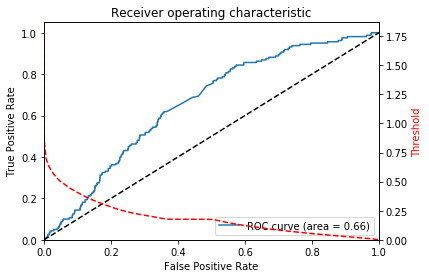

In [112]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])

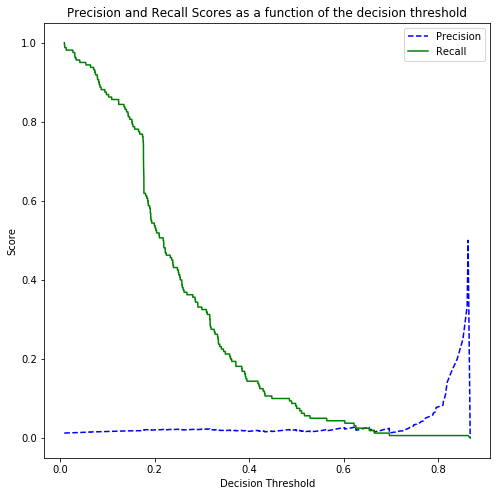

In [114]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

p, r, thresholds = precision_recall_curve(y_test, y_pred)
plot_precision_recall_vs_threshold(p, r, thresholds)

In [158]:
threshold = .135
y_class = np.where(y_pred > threshold, 1, 0)
roc_auc_score(y_test, y_class)

0.6351282013512451

In [177]:
# Save model
grid.best_estimator_.model.save('model5.h5')

## Part 3: Kaggle Competition

In [39]:
mailout_test = pd.read_csv('../data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\Mei\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [40]:
mailout_test.shape

(42833, 366)

In [41]:
LNR = mailout_test.LNR
LNR.head()

0    1754
1    1770
2    1465
3    1470
4    1478
Name: LNR, dtype: int64

In [162]:
mailout_test_clean, mailout_test_dropped = clean_data(mailout_test, feat_info, row_threshold=len(mailout_test))
mailout_test_clean.shape

(42833, 346)

In [44]:
# Read in cleaned test data
mailout_test_clean = pd.read_csv('../data/Udacity_MAILOUT_052018_TEST_clean.csv', sep=';')
lnr = mailout_test_clean.LNR
mailout_test_clean.drop(['LNR'], axis=1, inplace=True)

In [46]:
mailout_test_processed = preprocessor.transform(mailout_test_clean)

In [55]:
#test_pred = weighted.predict_classes(mailout_test_processed)
test_pred = grid.best_estimator_.predict_proba(mailout_test_processed)
#test_pred = model.predict_proba(mailout_test_processed)

42833/42833 [==============================] - 1s 30us/step


In [57]:
threshold = .135
y_class = np.where(test_pred[:,1] > threshold, 1, 0)
pd.value_counts(y_class)

0    27756
1    15077
dtype: int64

In [52]:
test_pred[:5]

array([[0],
       [0],
       [0],
       [0],
       [0]], dtype=int64)

In [58]:
# submit probabilities
submission = pd.DataFrame({'LNR':lnr, 'RESPONSE':test_pred[:,1]})
submission.head()

,LNR,RESPONSE
0,1754,0.449332
1,1770,0.296060
2,1465,0.009407
3,1470,0.019191
4,1478,0.061899


In [ ]:
submission.RESPONSE.value_counts()

In [60]:
submission.to_csv('keras_grid.csv', index=False)